In [3]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

2022-03-07 10:22:19.583074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 10:22:19.583108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
data = yf.download('0005.hk')
data['Prediction']=data['Close'].shift(-1)
data.drop('Volume',1,inplace=True)
data.dropna(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_16329/2856603818.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close,Prediction
Date,,,,,,
2000-01-03,111.0,111.5,107.50,108.0,55.387066,106.0
2000-01-04,106.0,106.5,105.00,106.0,54.361378,100.5
2000-01-05,101.0,102.0,99.50,100.5,51.540737,97.0
2000-01-06,101.0,102.0,96.25,97.0,49.745796,100.5
2000-01-07,98.5,101.0,97.50,100.5,51.540737,100.0


In [5]:
data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Prediction    0
dtype: int64

In [6]:
data_price=data["Prediction"]
train=data.drop("Prediction",1).values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb,len(data)-lb):
        X.append(data[i-(lb):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=6
X,y = processData(train,data_price,lb)
X_unseen=X[-30:]
X=X[:-30]
y_unseen=y[-30:]
y=y[:-30]
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)].reshape(-1,1),y[int(y.shape[0]*0.90):].reshape(-1,1)
# print(type(X_train))
print(X.shape)
print(y.shape)

(5501, 6, 5)
(5501,)


/tmp/ipykernel_16329/3791162125.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train=data.drop("Prediction",1).values


In [7]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(4950, 6, 5) (4950, 1) (551, 6, 5) (551, 1)


In [10]:
# Build the LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(units=64))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [11]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0)
history = model.fit(X_train,y_train,epochs=400,batch_size=20,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/400
248/248 [==============================] - 3s 8ms/step - loss: 1701.8701 - val_loss: 606.2601
Epoch 2/400
248/248 [==============================] - 2s 6ms/step - loss: 415.2867 - val_loss: 390.1451
Epoch 3/400
248/248 [==============================] - 2s 6ms/step - loss: 327.3097 - val_loss: 110.6426
Epoch 4/400
248/248 [==============================] - 2s 7ms/step - loss: 302.7049 - val_loss: 239.7058
Epoch 5/400
248/248 [==============================] - 2s 6ms/step - loss: 258.4493 - val_loss: 74.4804
Epoch 6/400
248/248 [==============================] - 2s 6ms/step - loss: 244.2961 - val_loss: 53.5875
Epoch 7/400
248/248 [==============================] - 2s 6ms/step - loss: 214.1715 - val_loss: 37.7612
Epoch 8/400
248/248 [==============================] - 2s 7ms/step - loss: 173.5040 - val_loss: 20.5391
Epoch 9/400
248/248 [==============================] - 2s 7ms/step - loss: 133.4392 - val_loss: 11.2090
Epoch 10/400
248/248 [==============================] - 2s 

In [12]:
y_pred = model.predict(X_test)

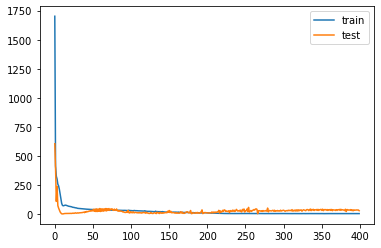

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

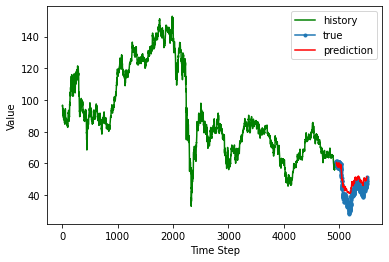

In [14]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

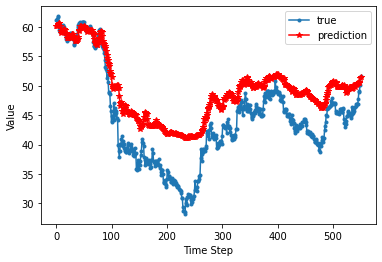

In [15]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [16]:
print(mean_absolute_percentage_error(y_test,y_pred)*100)
print(mean_squared_error(y_test,y_pred,squared=False))
print(r2_score(y_test,y_pred))

12.339723225892168
5.566791523026374
0.5157110847417237
